In [221]:
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import holidays
from datetime import date
import duckdb
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import scipy as sp 
import scipy.stats as stats
from statsmodels.stats.anova import anova_lm
from scipy.stats import * 
from datetime import timedelta

In [222]:
train = pd.read_csv('D:/Summer Practicum/1_Data/training_airlines.csv', low_memory=False)
test = pd.read_csv('D:/Summer Practicum/1_Data/testing_airlines.csv', low_memory=False)
validate = pd.read_csv('D:/Summer Practicum/1_Data/validation_airlines.csv', low_memory=False)

In [223]:
df = pd.concat([train,test,validate])
df.columns = df.columns.str.replace(' ', '')
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed:119
0,2022,2,4,20,3,2022-04-20,WN,WN,19393,WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,2022,4,12,25,7,2022-12-25,B6,B6,20409,B6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,2022,4,11,1,2,2022-11-01,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,2022,3,9,27,2,2022-09-27,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,2022,4,10,13,4,2022-10-13,WN,WN,19393,WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN


Add labels for airlines

In [224]:
#airline_names = pd.DataFrame({
#    "airline_name":["Alaska","American","JetBlue","Southwest","Spirit","Delta","Frontier","United","Hawaiian","Allegiant"],
#    "IATA_Code":["AS","AA","B6","WN","NK","DL","F9","UA","HA","G4"]
#})
#df = pd.merge(df,airline_names,left_on="Operating_Airline",right_on="IATA_Code",how="left")

If the flight is cancelled or diverted, set "flight" to zero. 

In [225]:
df.loc[df['Cancelled']=='1','Flights']==0
df.loc[df['Diverted']=='1','Flights']==0
df

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed:119
0,2022,2,4,20,3,2022-04-20,WN,WN,19393,WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,2022,4,12,25,7,2022-12-25,B6,B6,20409,B6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,2022,4,11,1,2,2022-11-01,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,2022,3,9,27,2,2022-09-27,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,2022,4,10,13,4,2022-10-13,WN,WN,19393,WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989163,2023,1,1,19,4,2023-01-19,UA,UA,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
989164,2022,4,11,9,3,2022-11-09,WN,WN,19393,WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
989165,2022,3,9,25,7,2022-09-25,DL,DL,19790,DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
989166,2022,4,11,15,2,2022-11-15,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN


## Is_Holiday
Create a Boolean column for if the flight occurred on a holiday

In [226]:
df['FlightDate'] = pd.to_datetime(df['FlightDate'])
df.columns = df.columns.str.replace(' ','')

us_holidays = holidays.US(years=range(df['FlightDate'].min().year,df['FlightDate'].max().year +1))
holiday_dates = {date for date, name in us_holidays.items()}

df['Is_Holiday'] = df['FlightDate'].dt.date.isin(holiday_dates)
df['Is_Delayed'] = (df['ArrDelay'] > 0).astype(int)

holiday_week = set()
for holiday in holiday_dates:
        # Add the holiday date itself
        holiday_week.add(holiday)
        
        # Add the 'window_days' before and after the holiday
        for i in range(1, 3 + 1):
            holiday_week.add(holiday + timedelta(days=i))
            holiday_week.add(holiday - timedelta(days=i))

# Create the new 'Is_Holiday_Window' boolean column
df['Is_Holiday_Week'] = df['FlightDate'].dt.date.isin(holiday_week)

AVNOA: check if there is a relationship between in arrival delays if the flight falls on a holiday 

In [227]:
avg_if_delayed = df[df['ArrDelayMinutes']>0]
model = smf.ols("ArrDelayMinutes ~ C(Is_Holiday_Week)",data=avg_if_delayed).fit()

#show ANOVA Table
anova_table = sm.api.stats.anova_lm(model,typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Is_Holiday_Week),4.407025e+06,1.0,767.04718,8.511329e-169
Residual,1.107688e+10,1927942.0,NaN,NaN


Test assumptions

In [228]:
sp.stats.shapiro(model.resid)

c:\ProgramData\anaconda3\envs\irenes_env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1927944.


ShapiroResult(statistic=np.float64(0.43955662775572546), pvalue=np.float64(1.3602981751902143e-223))

In [229]:
isholiday_false = avg_if_delayed[avg_if_delayed['Is_Holiday_Week']==False]['ArrDelayMinutes']
isholiday_true = avg_if_delayed[avg_if_delayed['Is_Holiday_Week']==True]['ArrDelayMinutes']
sp.stats.levene(isholiday_false,isholiday_true)

LeveneResult(statistic=np.float64(702.4500153807783), pvalue=np.float64(9.349622617718583e-155))

Plot relationships between Arrival Delay and Holiday Delays

## Scoring Dataframe
Create a dataframe of grouped values to get a performance score for each airline 

In [ ]:
airline_scores = df.groupby('Operating_Airline').agg({
    'Flights':'sum',
    'Diverted':'sum',
    'Cancelled':'sum',
    'ArrDelayMinutes':'sum',
    'CarrierDelay':'sum',
    'Is_Delayed':'sum'
}).reset_index()

#get average delay lengths
#avg_delay_len = df.groupby('Operating_Airline').agg(
#    Avg_Delay_Len = ('ArrDelayMinutes', lambda x:(x*df.loc[x.index,'Is_Delayed']).mean())
#).reset_index()
avg_delay_len = df.groupby

#average of delays if it is a holiday
temp = df[df['Is_Holiday_Week']==True]
temp_holiday_delays = temp.groupby('Operating_Airline')['ArrDelayMinutes'].mean().reset_index()
temp_holiday_delays=temp_holiday_delays.rename(columns={"ArrDelayMinutes":"Avg_Delay_if_Holiday"})

# merge dfs
airline_scores=airline_scores.merge(avg_delay_len,left_on="Operating_Airline",right_on="Operating_Airline")
airline_scores=airline_scores.merge(temp_holiday_delays,left_on="Operating_Airline",right_on="Operating_Airline")


In [231]:
# Proportion of all flights that are cancelled or divered 
airline_scores['Cancel_Diverted_Prop'] = 100*(airline_scores['Diverted'] + airline_scores['Cancelled']) /airline_scores['Flights']
# Prop. of total delays that were a carrier delay 
airline_scores['CarrierDelay_Prop'] = 100*airline_scores['CarrierDelay']/airline_scores['ArrDelayMinutes']
# Prop. of total flights that were delayed 
airline_scores['ArrDelay_Prop'] = 100*airline_scores['Is_Delayed']/airline_scores['Flights']
# difference between holiday and regular delay
airline_scores['Holiday_Diff'] = airline_scores['Avg_Delay_if_Holiday']-airline_scores['Avg_Delay_Len']

In [232]:
airline_scores

,Operating_Airline,Flights,Diverted,Cancelled,ArrDelayMinutes,CarrierDelay,Is_Delayed,Avg_Delay_Len,Avg_Delay_if_Holiday,Cancel_Diverted_Prop,CarrierDelay_Prop,ArrDelay_Prop,Holiday_Diff
0,AA,893607.0,2383.0,20546.0,17080905.0,5872145.0,356497,13.955286,19.869873,2.565893,34.378418,39.894159,5.914586
1,AS,234782.0,796.0,5516.0,2770778.0,785105.0,93081,8.787981,12.962462,2.688451,28.335182,39.645714,4.174482
2,B6,279426.0,983.0,7417.0,6752853.0,2761245.0,126946,17.938599,27.663234,3.006163,40.890050,45.430991,9.724635
3,DL,913205.0,1775.0,13895.0,11448577.0,5422530.0,283685,8.981899,13.816312,1.715935,47.364227,31.064766,4.834412
4,F9,159681.0,270.0,3686.0,3814346.0,1189601.0,76881,17.821999,25.034923,2.477439,31.187548,48.146617,7.212924
5,G4,115918.0,318.0,2527.0,2832173.0,763001.0,59215,18.290549,25.669740,2.454321,26.940480,51.083525,7.379191
6,HA,76512.0,86.0,591.0,1071947.0,474845.0,43503,10.349889,14.722913,0.884829,44.297433,56.857748,4.373024
7,NK,243562.0,386.0,6563.0,4392355.0,1227801.0,99511,13.415391,19.214881,2.853072,27.953137,40.856538,5.799490
8,UA,657632.0,1691.0,9091.0,9684877.0,3041332.0,226663,10.672004,17.176625,1.639519,31.402898,34.466541,6.504621
9,WN,1346910.0,2746.0,36873.0,17643944.0,5331864.0,561962,9.492107,14.186207,2.941473,30.219230,41.722313,4.694100


# Final Total Scores

In [233]:
values = ('ArrDelay_Prop','Cancel_Diverted_Prop','Holiday_Diff','Avg_Delay_Len','CarrierDelay_Prop')
scores = ('Delay_Score','Div_Can_Score','Holiday_Score','Len_Delay_Score','Carrier_Del_Score')

scoring_df = pd.DataFrame()
scoring_df['Airline'] = airline_scores['Operating_Airline']
#iterate through each scoring critera 
for value, score in zip(values,scores):
    #calculate the quantiles for the score
    q1 = airline_scores[value].quantile(0.25)
    q2 = airline_scores[value].median()
    q3 = airline_scores[value].quantile(0.75)

    #calculate the score for each airline and assign it to a new column
    q1_string = score + "q1"
    q2_string = score + "q2"
    q3_string = score + "q3"

    # sum all of the columns 
    scoring_df[q1_string] = np.where((airline_scores[value] <= q1),1,0)
    scoring_df[q3_string] = np.where((airline_scores[value] >= q3),0.25,0)
    scoring_df[q2_string] = np.where((airline_scores[value] > q1) & (airline_scores[value] < q3),0.5,0)


# sum the scores
scoring_df['Total_Score'] = scoring_df.drop(columns=['Airline']).sum(axis=1)
scoring_df[['Airline','Total_Score']].sort_values(by='Total_Score', ascending=False)
scoring_df[(scoring_df['Airline']=='AS')|(scoring_df['Airline']=='B6')|(scoring_df['Airline']=='G4')|(scoring_df['Airline']=='F9')]

,Airline,Delay_Scoreq1,Delay_Scoreq3,Delay_Scoreq2,Div_Can_Scoreq1,Div_Can_Scoreq3,Div_Can_Scoreq2,Holiday_Scoreq1,Holiday_Scoreq3,Holiday_Scoreq2,Len_Delay_Scoreq1,Len_Delay_Scoreq3,Len_Delay_Scoreq2,Carrier_Del_Scoreq1,Carrier_Del_Scoreq3,Carrier_Del_Scoreq2,Total_Score
1,AS,1,0.00,0.0,0,0.00,0.5,1,0.00,0.0,1,0.00,0.0,1,0.00,0.0,4.50
2,B6,0,0.00,0.5,0,0.25,0.0,0,0.25,0.0,0,0.25,0.0,0,0.25,0.0,1.50
4,F9,0,0.25,0.0,0,0.00,0.5,0,0.25,0.0,0,0.25,0.0,0,0.00,0.5,1.75
5,G4,0,0.25,0.0,0,0.00,0.5,0,0.25,0.0,0,0.25,0.0,1,0.00,0.0,2.25


In [234]:
(df['Is_Delayed']/df['Flights']).mean()

np.float64(0.39176019840548154)

# Region Weather relationship
a brief detour to look at if certain regions are more influenced by weather

In [235]:
#creating a region column
def state_to_region(state):
    West = ["WA", "MT", "ID", "WY", "OR", "CA", "NV", "UT", "CO", "AZ", "NM", "AK", "HI"]
    South = ["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", "FL", "GA", "SC", "NC", "VA", "MD", "DE"]
    Northeast = ["PA", "NJ", "NY", "CT", "MA", "RI", "ME", "NH", "VT"]
    Midwest = ["ND", "SD", "NE", "KS", "MO", "IA", "MN", "WI", "IL", "IN", "OH", "MI"]
    if state in West:
        return "West"
    elif state in South:
        return "South"
    elif state in Northeast:
        return "Northeast"
    elif state in Midwest:
        return "Midwest"
    
df["Region"] = df["OriginState"].map(state_to_region)

<Axes: xlabel='Region', ylabel='ArrDelay'>

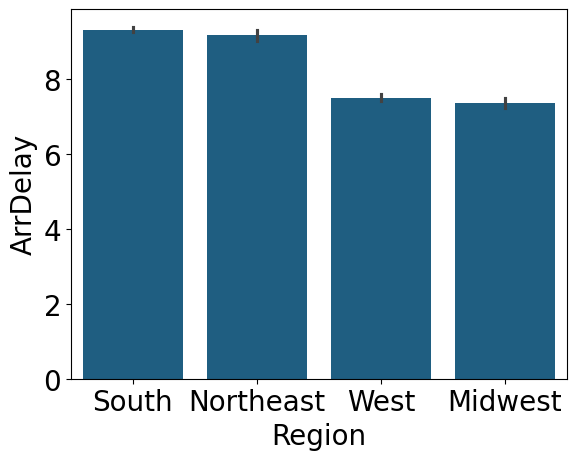

In [245]:
df = df.reset_index(drop=True)
sns.barplot(x='Region',y='ArrDelay',data=df)

# Plots

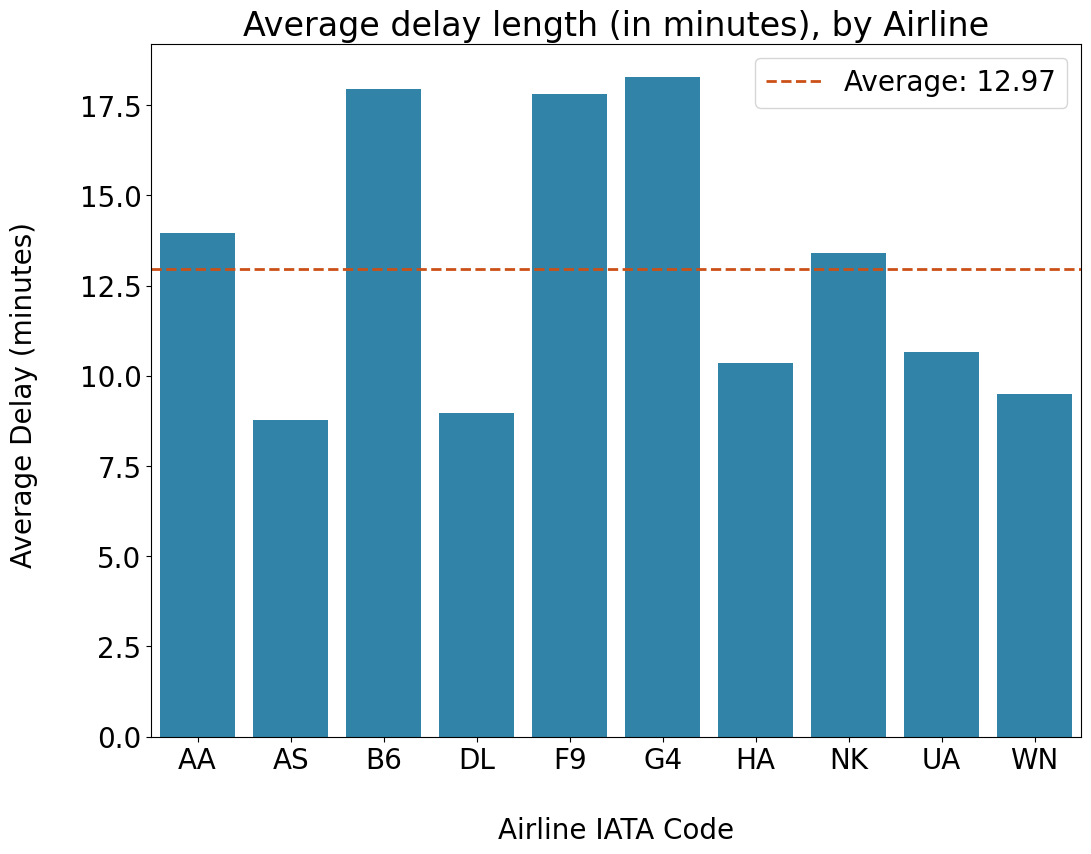

In [248]:
plt.figure(figsize=(12,9))
plt.rcParams.update({'font.size':20})
sns.barplot(x="Operating_Airline",y="Avg_Delay_Len",color="#1E8ABC",data=airline_scores)
avg = np.mean(airline_scores["Avg_Delay_Len"])
plt.axhline(y=avg,linestyle="--",color="#CB5017",linewidth=2,label=f'Average: {avg:.2f}')

plt.legend()

plt.title("Average delay length (in minutes), by Airline")
plt.xlabel("Airline IATA Code",labelpad=30)
plt.ylabel("Average Delay (minutes) ",labelpad=30)

plt.show()

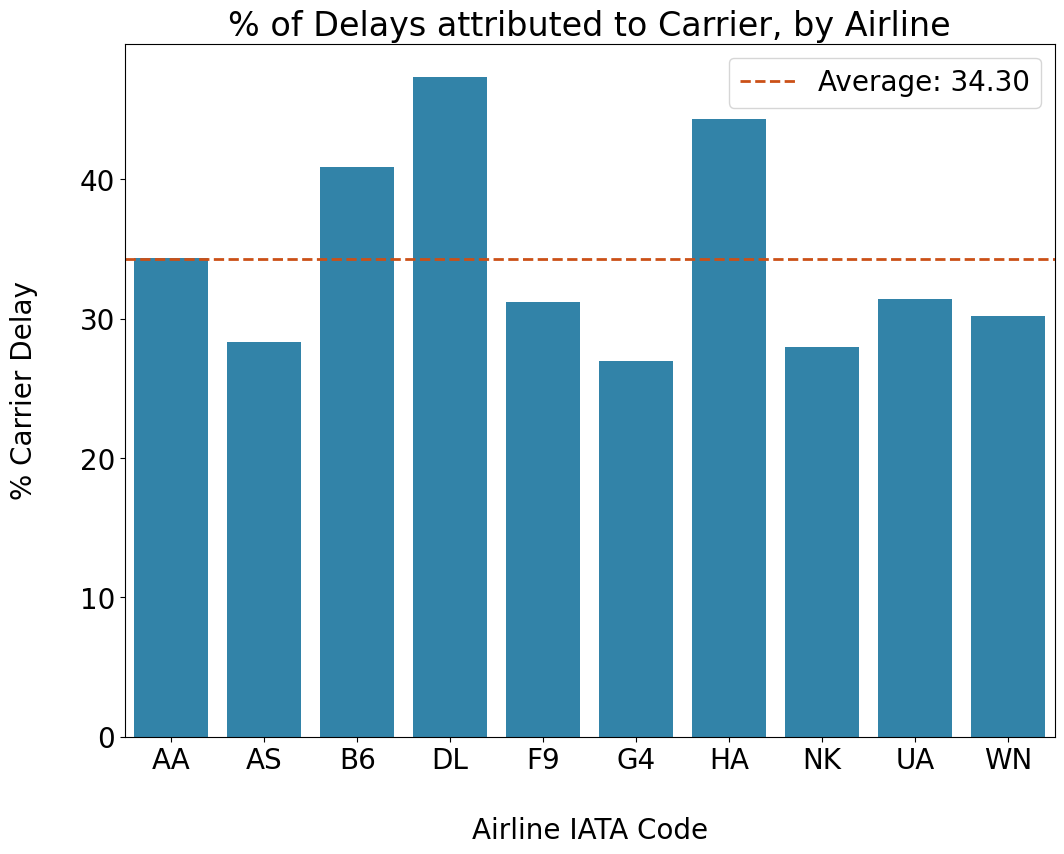

In [238]:
plt.figure(figsize=(12,9))
plt.rcParams.update({'font.size':20})
sns.barplot(x="Operating_Airline",y="CarrierDelay_Prop",color="#1E8ABC",data=airline_scores)
avg = np.mean(airline_scores["CarrierDelay_Prop"])
plt.axhline(y=avg,linestyle="--",color="#CB5017",linewidth=2,label=f'Average: {avg:.2f}')

plt.legend()

plt.title("% of Delays attributed to Carrier, by Airline")
plt.xlabel("Airline IATA Code",labelpad=30)
plt.ylabel("% Carrier Delay",labelpad=30)

plt.show()

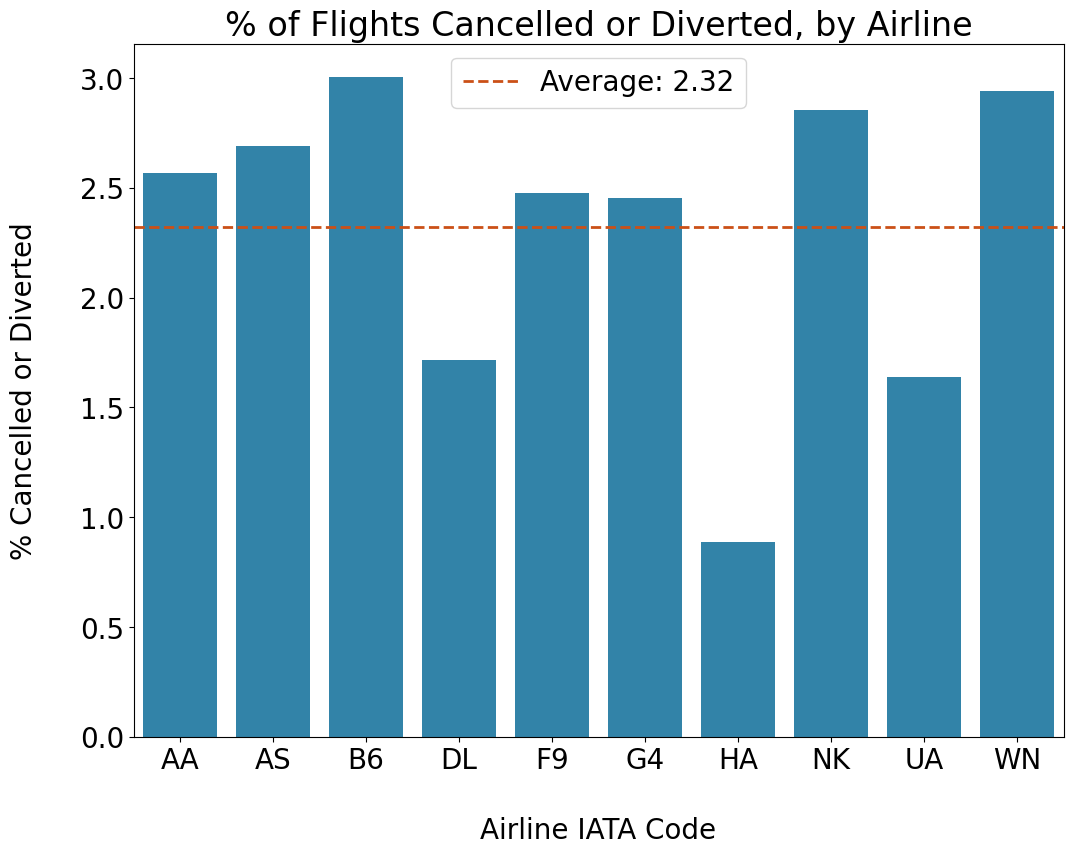

In [239]:
plt.figure(figsize=(12,9))
plt.rcParams.update({'font.size':20})
sns.barplot(x="Operating_Airline",y="Cancel_Diverted_Prop",color="#1E8ABC",data=airline_scores)
avg = np.mean(airline_scores["Cancel_Diverted_Prop"])
plt.axhline(y=avg,linestyle="--",color="#CB5017",linewidth=2,label=f'Average: {avg:.2f}')

plt.legend()

plt.title("% of Flights Cancelled or Diverted, by Airline")
plt.xlabel("Airline IATA Code",labelpad=30)
plt.ylabel("% Cancelled or Diverted",labelpad=30)

plt.show()

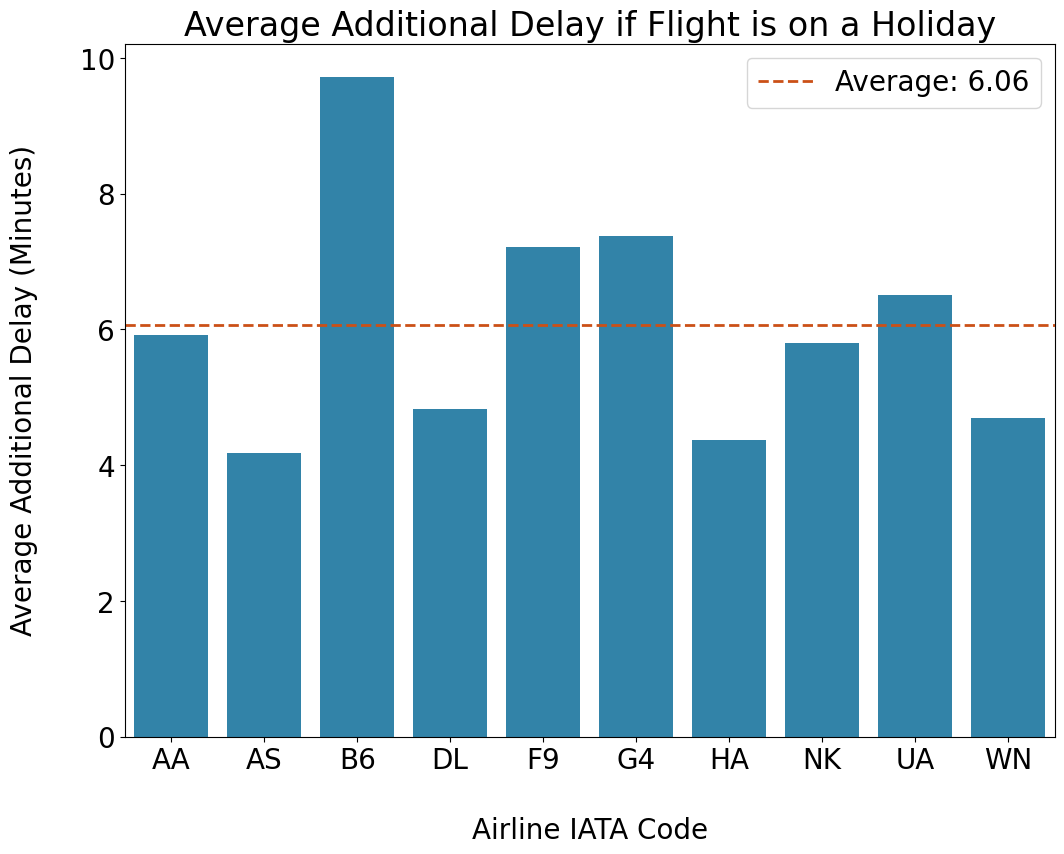

In [247]:
plt.figure(figsize=(12,9))
plt.rcParams.update({'font.size':20})
sns.barplot(x="Operating_Airline",y="Holiday_Diff",color="#1E8ABC",data=airline_scores)
avg = np.mean(airline_scores["Holiday_Diff"])
plt.axhline(y=avg,linestyle="--",color="#CB5017",linewidth=2,label=f'Average: {avg:.2f}')

plt.legend()

plt.title("Average Additional Delay if Flight is on a Holiday")
plt.xlabel("Airline IATA Code",labelpad=30)
plt.ylabel("Average Additional Delay (Minutes)",labelpad=30)

plt.show()

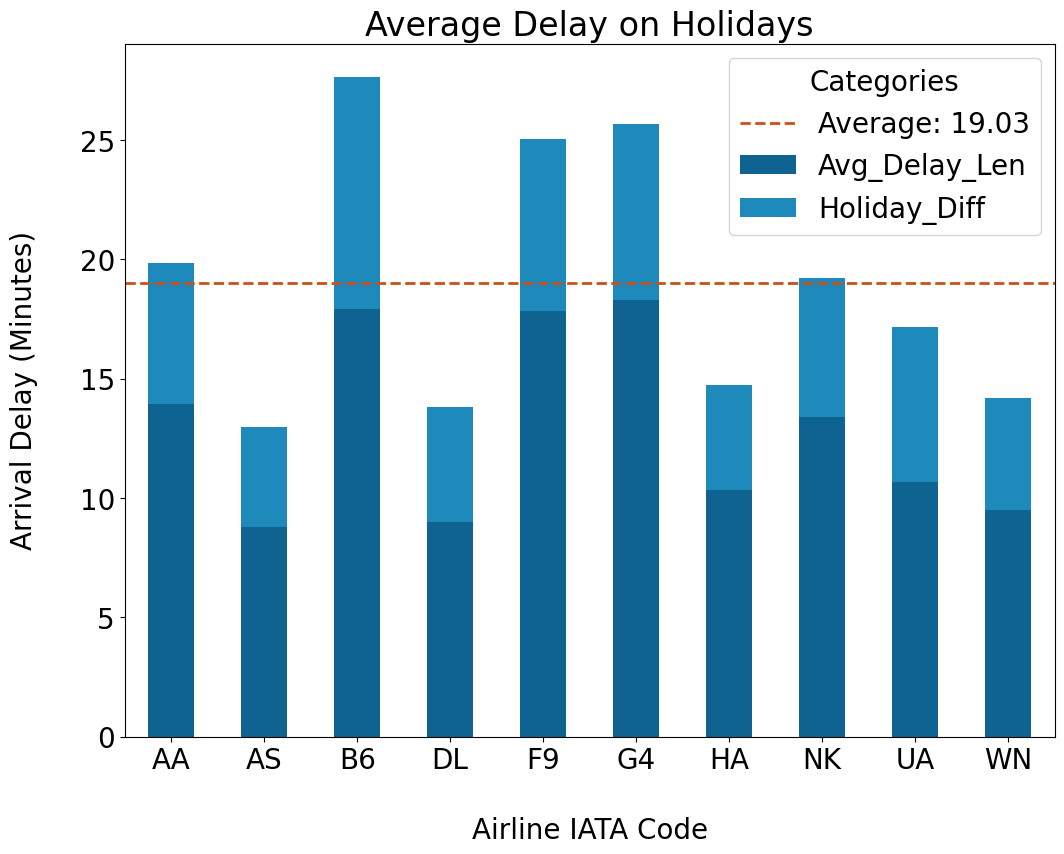

In [255]:
ax = airline_scores.plot.bar(x='Operating_Airline', y=['Avg_Delay_Len', 'Holiday_Diff'], stacked=True, figsize=(12, 9))

plt.rcParams.update({'font.size':20})

avg = np.mean(airline_scores["Holiday_Diff"] + airline_scores["Avg_Delay_Len"])
plt.axhline(y=avg,linestyle="--",color="#CB5017",linewidth=2,label=f'Average: {avg:.2f}')

plt.title('Average Delay on Holidays')
plt.xlabel('Airline IATA Code', labelpad=30)
plt.ylabel('Arrival Delay (Minutes)', labelpad=30)
plt.xticks(rotation=0) # Optional: rotate x-axis labels if needed
plt.legend(title='Categories')

plt.show()
